In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from contextlib import contextmanager
from copy import deepcopy
import math

import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange

from dev_diffusionMLP  import *

In [2]:

@torch.no_grad()
def sample(model, x, steps, eta):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v = model(x, ts * log_snrs[i]).float()

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred

In [3]:
seed = 0

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

# 更新模型的潜在维度和隐藏层维度
latent_dim = (256, 8)
hidden_dims = [10000, 10000]  # Example of hidden dimensions
max_freq = 4  # Example max frequency for Fourier features
num_bands = 16  # Number of frequency bands

# 初始化模型
# model = Diffusion().to(device)
diffusion_model = LatentDiffusionModel(latent_dim, hidden_dims, max_freq, num_bands).to(device)
# diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/latent_diffusion.pth"
diffusion_ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/latent_diffusion.pth"
diffusion_ckpt = torch.load(diffusion_ckpt_path)
diffusion_model.load_state_dict(diffusion_ckpt['model'])

print('Diffusion Model parameters:', sum(p.numel() for p in diffusion_model.parameters()))

scaler = torch.cuda.amp.GradScaler()
rng = torch.quasirandom.SobolEngine(1, scramble=True)
ema_decay = 0.998
steps = 1000
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.


Using device: cuda:3


OutOfMemoryError: CUDA out of memory. Tried to allocate 382.00 MiB (GPU 0; 23.69 GiB total capacity; 620.25 MiB already allocated; 346.25 MiB free; 624.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
torch.__version__

'1.12.1'

In [1]:
import os
# os.environ["http_proxy"]="http://115.27.161.58:7890"
# os.environ["https_proxy"]="http://115.27.161.58:7890"
# os.environ["ALL_PROXY"]="http://115.27.161.58:7890"
os.environ["ALL_PROXY"]="http://127.0.0.1:7890"

import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])

print("version string: ", version_str)
# version_str = "py310_cu117_pyt1131"
!pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

AttributeError: 'NoneType' object has no attribute 'replace'

In [4]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np

from dataset import get_dataset
from logger import Logger
from core.models import get_model
from core import solver_dict
from init import get_cfg, setup_seed, dev_get_cfg

# preparer configuration
cfg  =dev_get_cfg()

device = "cuda:0"

# set random seed
setup_seed(cfg["rand_seed"])


# prepare models
ModelClass = get_model(cfg["model"]["model_name"])
model = ModelClass(cfg)
ckpt_path = "/home/ziran/se3/EFEM/lib_shape_prior/dev_ckpt/selected.pt"
ckpt = torch.load(ckpt_path)


# 注意不是model.load_state_dict,
# 参见 lib_shape_prior/core/solver_v2.py, lib_shape_prior/core/models/model_base.py

model.network.load_state_dict(ckpt['model_state_dict'])
model.network.to(device)

| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Nov-08-15:57:32 | Set GPU: 0 ...   [post_config.py:99]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Nov-08-15:57:32 | Save configuration to local file...   [post_config.py:105]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Nov-08-15:57:32 | DGCNN use Dynamic Graph (different from the input topology)   [vec_dgcnn_atten.py:50]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Nov-08-15:57:32 | 2.016M params in encoder   [misc.py:16]
| sim3vec-mugs | user-AS-4124GS-TNR | INFO | Nov-08-15:57:32 | 0.790M params in decoder   [misc.py:16]
| sim3vec-mugs | user-AS-4124GS-TNR | WARNING | Nov-08-15:57:32 | Network Components != Optimizer Config   [model_base.py:31]


Please check the configuration
--------------------------------------------------------------------------------
{'dataset': {'aug_ratio': 0.7,
             'categories': ['03797390'],
             'data_root': '../data/ShapeNetV1_SDF',
             'dataset_name': 'shapenet_new2',
             'dataset_proportion': [1.0, 1.0],
             'dataset_root': 'resource/data/XXXX',
             'dep_max_use_view': 12,
             'dep_min_use_view': 4,
             'dep_total_view': 12,
             'depth_postfix': '_dep_small',
             'field_mode': 'sdf',
             'indices': {'test_index': 'None',
                         'train_index': 'None',
                         'val_index': 'None'},
             'input_mode': 'dep',
             'n_pcl': 512,
             'n_query_eval': 10000,
             'n_query_nss': 1024,
             'n_query_uni': 1024,
             'noise_std': 0.01,
             'num_workers': 8,
             'pin_mem': True,
             'ram_cache': True,
  

SIM3Recon(
  (network_dict): ModuleDict(
    (encoder): VecDGCNN_att(
      (global_conv_list): ModuleList(
        (0): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (1): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (2): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivation(
            (act_func): LeakyReLU(negative_slope=0.2)
            (lin_dir): VecLinear()
          )
          (act_func): LeakyReLU(negative_slope=0.2)
        )
        (3): VecLinearNormalizeActivate(
          (lin): VecLinear()
          (act): VecActivat

In [5]:
noise = torch.randn([3, 256, 8], device=device)
fakes = sample(diffusion_model, noise, steps, eta)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
# feat = torch.cat([pred_so3_feat, 
#                   pred_inv_feat.unsqueeze(2), 
#                   pred_scale.unsqueeze(1).unsqueeze(1).repeat(1,256,1), 
#                   pred_center.repeat(1,256,1)], dim=2)
pred_so3_feat = fakes[:,:,:3].to(device)
pred_inv_feat = fakes[:,:,3].to(device)
pred_scale = fakes[:,:,4].mean(dim=1).to(device)
pred_center = fakes[:,:,5:].mean(dim=1).unsqueeze(1).to(device)
print(pred_so3_feat.shape, pred_inv_feat.shape, pred_scale.shape, pred_center.shape)

torch.Size([3, 256, 3]) torch.Size([3, 256]) torch.Size([3]) torch.Size([3, 1, 3])


In [ ]:
pred_so3_feat

In [ ]:
pred_inv_feat

In [ ]:
pred_scale

In [ ]:
pred_center

In [7]:
N = 64

space_dim = [N, N, N]  # 示例为一个50x50x50的网格


di = 1
# 创建一个网格，这里我们使用np.linspace来产生线性间隔的点
x = np.linspace(-di, di, space_dim[0])
y = np.linspace(-di, di, space_dim[1])
z = np.linspace(-di, di, space_dim[2])

# 用np.meshgrid得到每个维度的点阵
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# 将这些点整理成query的形式，每行是一个点的坐标
query = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)

query = torch.tensor(query,dtype=torch.float32).to(device)
query = query.repeat(pred_so3_feat.shape[0], 1, 1)
query.shape

torch.Size([3, 262144, 3])

In [8]:
embedding = {
            "z_so3": pred_so3_feat, # [B, 256, 3]
            "z_inv": pred_inv_feat, # [B, 256]
            "s": pred_scale, # [B]
            # "t": centroid.unsqueeze(1), # [B, 1, 3]
            "t": pred_center, # [B, 1, 3]
        }

sdf_hat = model.network.decode(  # SDF must have nss sampling
            query,
            None,
            embedding,
            return_sdf=True,
        )

In [9]:
sdf_grid = sdf_hat.reshape(-1, space_dim[0], space_dim[1], space_dim[2]).to("cpu").detach().numpy()
data = sdf_grid[0]

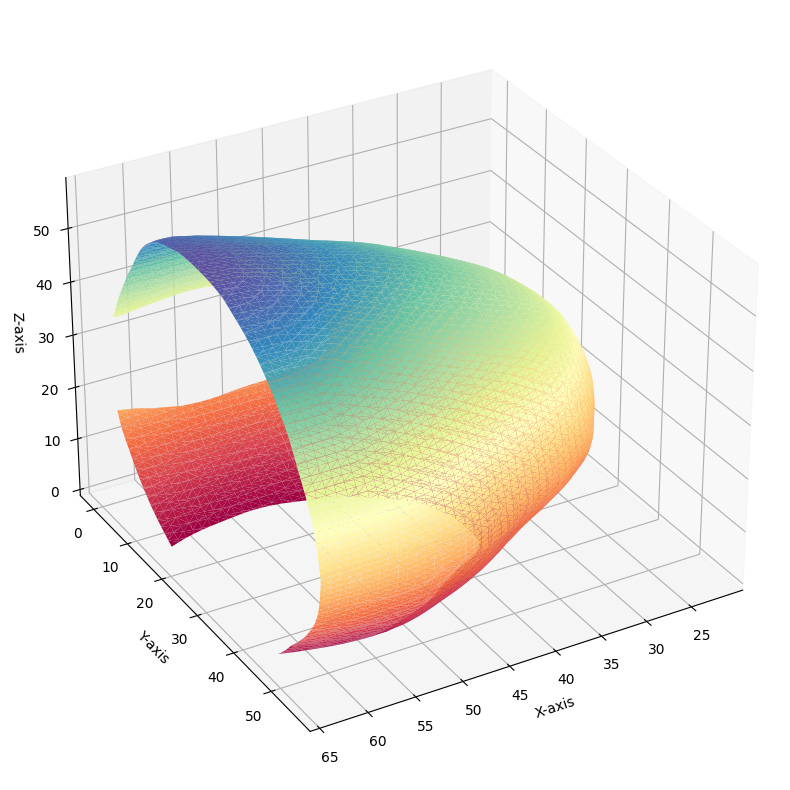

In [10]:
%matplotlib inline
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 使用 Marching Cubes 算法提取等值面
verts, faces, normals, values = measure.marching_cubes(data, level=0.01)

# 创建一个新的图形
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制等值面
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)

# 设置图形的视角和轴标签
ax.view_init(30, 60)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()
